# Super Classy

## Team Members:  
- Katlego Thobye
- Njabulo Nxumalo
- Thato Matlou
- Seema Masekwameng
- Khuthadzo Mamushiana
- Matlala Nyama
- Lerato Ntoene

## Predict Overview: EA Twitter Sentiment Classification

Companies would like to determine how people perceive climate change and whether or not they believe it is a real threat. 
Our mission is to deliver a precise and durable solution to this objective, granting companies the ability to tap into a wide range of consumer sentiments across various demographics and geographic regions. This, in turn, enhances their understanding and empowers them to shape future marketing strategies based on valuable insights.

## Importing Packages

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
import string
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Loading Data

Our data set consists of two features and a label. The main feature is the `message` column that contains a tweet related to global warming. The label `sentiment` catagorizes tweets according to four classes, namely `news`, `neutral`, `pro` and `anti`. Our aim will be to create a machine learning model that will be able to acurately classify any tweet according to these four buckets based on the textual message data of a tween only. 

In [70]:
df_test = pd.read_csv("test_with_no_labels.csv")
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [71]:
df_train = pd.read_csv("train.csv")
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## Exploratory Data Analysis

There are `15819 categorized observations` in the train dataset and `10546 uncategorized observations` in the test dataset. 

In [72]:
print("There are", df_train.shape[0], "categorized observations.")
print("There are", df_test.shape[0], "uncategorized observations.")

There are 15819 categorized observations.
There are 10546 uncategorized observations.


There are no null values in either the train or test datasets.

In [73]:
#check null values
print("There are",df_train.isnull().sum().sum(), "null values in the train dataset.") 
print("There are",df_test.isnull().sum().sum(), "null values in the test dataset.")

There are 0 null values in the train dataset.
There are 0 null values in the test dataset.


The `tweetid` feature simply uniquely identifies each tweet and most probably will add no real value in classification machine model training.

In [74]:
df_train['tweetid'].nunique()

15819

In [75]:
df_train = df_train.drop('tweetid', axis=1)
df_train.head()

,sentiment,message
0,1,PolySciMajor EPA chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In order to analyze the length of tweets, we created a new feature called `size` which is a count of the `number of characters per tweet`.

In [76]:
size = [len(tweet) for tweet in df_train['message']]
df_train['size'] = size

The tweets range from `14` to `208` characters in length. The average size of a tweet is about `124` characters long. Most tweets are `140` characters in length.

In [77]:
print("Most tweets are",df_train['size'].mode()[0], "characters in length.")
df_train['size'].describe()


Most tweets are 140 characters in length.


count    15819.000000
mean       123.774132
std         23.332433
min         14.000000
25%        114.000000
50%        133.000000
75%        140.000000
max        208.000000
Name: size, dtype: float64

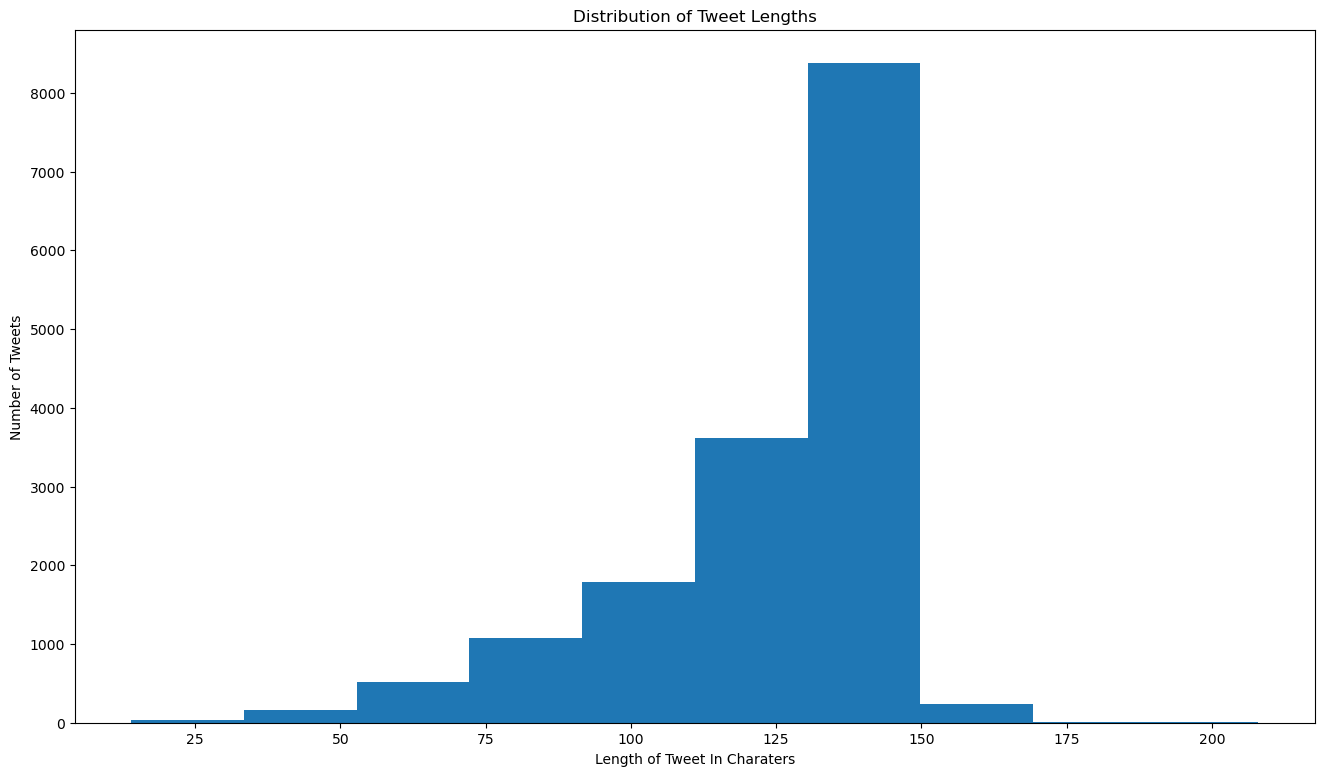

In [78]:
plt.figure( figsize=(16,9))
plt.hist(df_train['size'])
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet In Charaters") #X-label of the data
plt.ylabel("Number of Tweets")      #Y_label of the data
plt.show()

### Cleaning Data

In order to process the tweet messages more effectively the tweets are cleaned using the `clean` function defined in the code cell below.
The clean function does the following.
- Converts all tweet text to lowercase.
- Removes URLs.
- Removes punctuation.
- Removes numbers.
- Removes stopwords.
- Removes line-break code syntax.  

In [79]:
stopword=set(stopwords.words('english'))  
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    return text

In [80]:
df_train["message"] = df_train["message"].apply(clean)

In [81]:
df_train.head()

,sentiment,message,size
0,1,polyscimajor epa chief doesnt think carbon dio...,140
1,1,like lack evidence anthropogenic global warming,62
2,2,rt rawstory researchers say three years act cl...,140
3,1,todayinmaker wired pivotal year war climate ...,99
4,1,rt soynoviodetodas racist sexist climate chan...,122


### Generating Wordcloud To Analyse Commonly Used Phrases

In [82]:
from wordcloud import WordCloud,ImageColorGenerator
text = " ".join(i for i in df_train["message"])
text = str(text)

Using a `Word Cloud`, we attempt to visualize which words are and phrases are most commonly used in tweets related to global warming.
The top three phrases seem to be:

- Climate Change
- Global Warming
- RT
- Change RT 
- Believe Climate

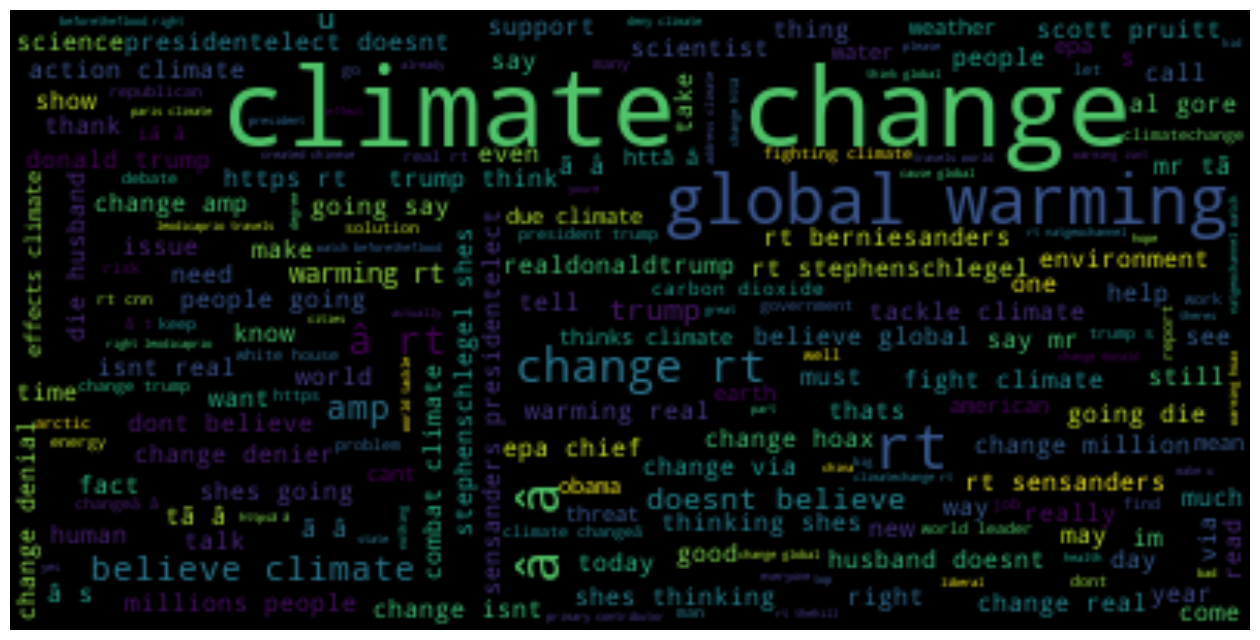

In [83]:
wordcloud = WordCloud()
tweet_cloud = wordcloud.generate(text)
plt.figure( figsize=(16,9))
plt.imshow(tweet_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The `RT` (an abbreviation of 'retweet') could signal that many individuals either share the same sentiments surrounding climate change or are active in attempting to engage with others on the topic based on information shared by others.

In [84]:
has_rt = lambda x: 'rt' in x
df_train['rt'] = [1 if has_rt(i) else 0 for i in df_train['message']]
#df_train['rt'] = df_train['message'].apply(has_rt)
df_train.head()


,sentiment,message,size,rt
0,1,polyscimajor epa chief doesnt think carbon dio...,140,0
1,1,like lack evidence anthropogenic global warming,62,0
2,2,rt rawstory researchers say three years act cl...,140,1
3,1,todayinmaker wired pivotal year war climate ...,99,0
4,1,rt soynoviodetodas racist sexist climate chan...,122,1


In [85]:
rt_counts = df_train["rt"].value_counts()
rt_counts

rt
1    10579
0     5240
Name: count, dtype: int64

### Generating a Pie Chart for Retweet Analysis

Most tweets have an `rt` which means it is highly likely if not certain that they are `Retweets`.

According to [twitter.com](https://help.twitter.com/en/using-twitter/retweet-faqs#:~:text=Twitter's%20Retweet%20feature%20helps%20you,re%2Dposting%20someone%20else's%20content.):
 
'A Retweet is a re-posting of a Tweet. Twitter's Retweet feature helps you and others quickly share that Tweet with all of your followers. You can Retweet your own Tweets or Tweets from someone else. Sometimes people type "RT" at the beginning of a Tweet to indicate that they are re-posting someone else's content. This isn't an official Twitter command or feature, but signifies that they are quoting another person's Tweet.'

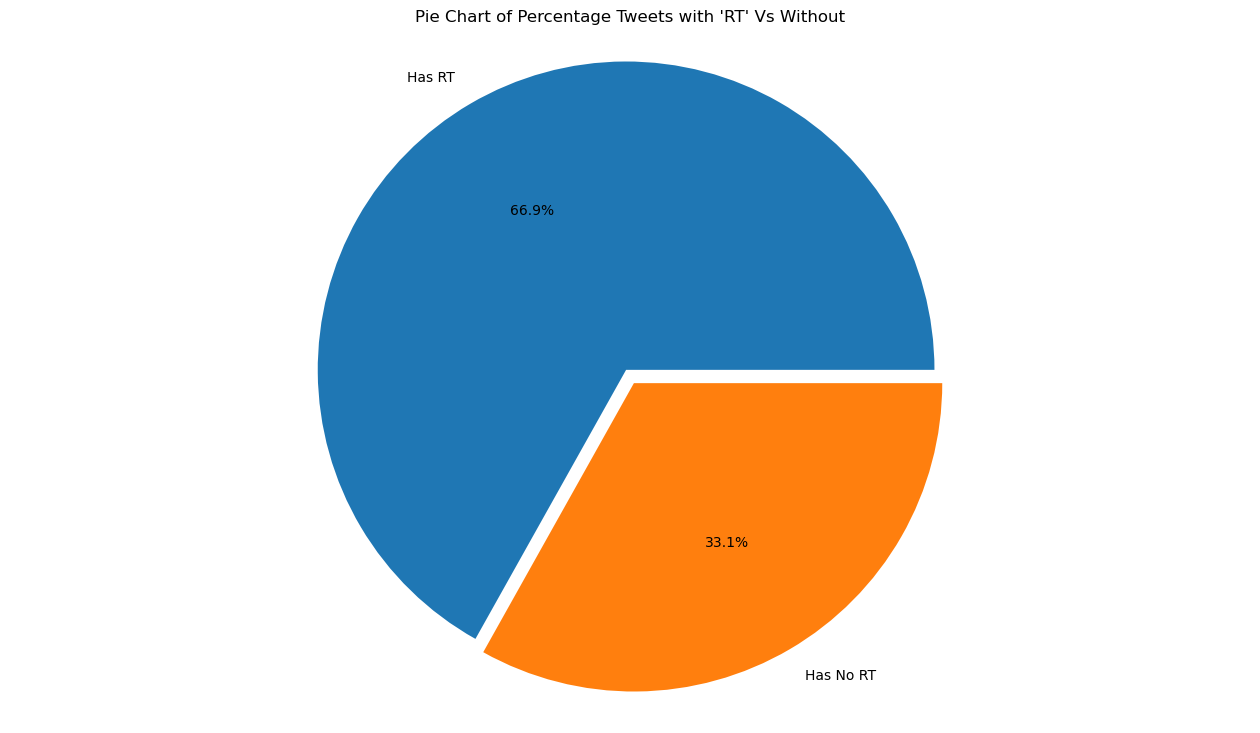

In [86]:
rt_counts = df_train["rt"].value_counts()
plt.figure( figsize=(16,9))
plt.pie(rt_counts, labels=["Has RT", "Has No RT"], explode=[0.05,0], autopct='%1.1f%%')
plt.title("Pie Chart of Percentage Tweets with 'RT' Vs Without")
plt.axis('equal')
plt.show()

Plotting the distribution of classes in our dataset we see that most tweets are `Pro` (display belief in) global warming and climate change (more than twice any other class). Other than that, alot of the tweets are `News` related. A fewer amount of the tweets are `Neutral` and the least amount of tweets are `Anti` (show little or no signs of belief in) global warming or climate change. 

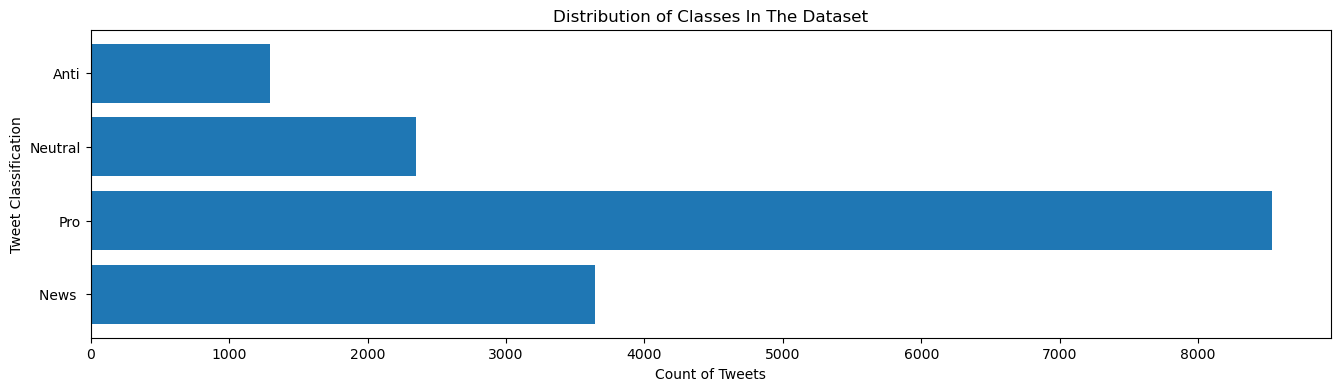

In [87]:
#Create a barplot for the train dataset classes
senti_counts = df_train["sentiment"].value_counts()
news = senti_counts[2] 
pro = senti_counts[1]   
neutral = senti_counts[0]
anti = senti_counts[-1]  

plt.figure( figsize=(16,4))
plt.barh(['News ','Pro','Neutral','Anti'], [news,pro,neutral,anti]) #Use matplotlib horizontal bar graph to compare classes of tweets.
plt.xlabel('Count of Tweets') #X-label of the data
plt.ylabel('Tweet Classification') #Y_label of the data 
plt.title('Distribution of Classes In The Dataset') #Give the data a title 'Dataset lables distribution'
plt.show() ##Display the dataset


### Analyzing The Overall Sentiment of The Data

The `sentiment_score` function is used to get a better idea of the what the underlying sentiment each classification has and to see if any if the classes correlate in term of it. The sentiment analyzer gives each tweet a score between `0` and `1` for each catagory of `positive`, `negative` and `neutral`. If tthe primary overall sentiment of a class is neutral then the function will output a secondary sentiment score to give the best overall picture of the general sentiment of each class.

In [88]:
def sentiment_score(df):
    result = []
    sentiments = SentimentIntensityAnalyzer()
    df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["message"]]
    df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["message"]]
    df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["message"]]
    a = sum(df["Positive"])
    b = sum(df["Negative"])
    c = sum(df["Neutral"])
    if (a>b) and (a>c):
        result.append("Positive 😊")
    elif (b>a) and (b>c):
        result.append("Negative 😠")
    else:
        result.append("Neutral 🙂")
    if result[0] == "Neutral 🙂":
        if a > b:
            result.append("Positive 😊")
        else:
            result.append("Negative 😠")
    
    return result

First we apply the `sentiment_score` function to the dataset as a whole.

In [89]:
set_sentiment = sentiment_score(df_train)

print("The dataset is mostly", set_sentiment[0], "in sentiment")
print("The dataset as a whole has an overall underlying sentiment of", set_sentiment[-1])

The dataset is mostly Neutral 🙂 in sentiment
The dataset as a whole has an overall underlying sentiment of Negative 😠


Then the `sentiment_score` function is applied to each class individually.

In [90]:
df_news = df_train.copy()[df_train['sentiment'] == 2]
news_sentiment = sentiment_score(df_news)
print("The news class is mostly", news_sentiment[0], "in sentiment")
print("The news class has an overall underlying sentiment of", news_sentiment[-1])

The news class is mostly Neutral 🙂 in sentiment
The news class has an overall underlying sentiment of Negative 😠


In [91]:
df_pro = df_train.copy()[df_train['sentiment'] == 1]
pro_sentiment = sentiment_score(df_pro)
print("The pro class is mostly", pro_sentiment[0], "in sentiment")
print("The pro class has an overall underlying sentiment of", pro_sentiment[-1])

The pro class is mostly Neutral 🙂 in sentiment
The pro class has an overall underlying sentiment of Negative 😠


In [94]:
df_neutral = df_train.copy()[df_train['sentiment'] == 0]
neutral_sentiment = sentiment_score(df_neutral)
print("The anti class is mostly", neutral_sentiment[0], "in sentiment")
print("The anti class has an overall underlying sentiment of", neutral_sentiment[-1])

The anti class is mostly Neutral 🙂 in sentiment
The anti class has an overall underlying sentiment of Positive 😊


In [93]:
df_anti = df_train.copy()[df_train['sentiment'] == -1]
anti_sentiment = sentiment_score(df_anti)
print("The neutral class is mostly", anti_sentiment[0], "in sentiment")
print("The neutral class has an overall underlying sentiment of", anti_sentiment[-1])

The neutral class is mostly Neutral 🙂 in sentiment
The neutral class has an overall underlying sentiment of Negative 😠


Although the entire dataset is mostly `neutral` in sentiment, it is slightly biased towards the `negative` side in all of the four classes. The `neutral` class is the only exception. It has an underlying overall sentiment of `positive`.